In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import seaborn as sns
!pip install spiderplot
import spiderplot as sp


ModuleNotFoundError: No module named 'geopandas'

In [2]:
# Casos COVID
#As colunas SG, SRAG e OB são, respectivamente, Síndrome Gripal, Síndrome Respiratória Aguda e Óbitos
# load data in a data frame

df = pd.read_csv('dados_covid_bairro_data_lin.csv', sep=';', encoding='iso-8859-1')

df['DATA'] = pd.to_datetime(df['DATA'])

# some statistics
df.describe()


,ID,SG,SRAG,OB
count,116246.000000,116246.000000,116246.000000,116246.000000
mean,240.122172,0.114929,0.042178,0.012766
std,147.933477,0.447113,0.221674,0.116402
min,1.000000,0.000000,0.000000,0.000000
25%,114.000000,0.000000,0.000000,0.000000
50%,227.500000,0.000000,0.000000,0.000000
75%,361.000000,0.000000,0.000000,0.000000
max,621.000000,14.000000,4.000000,4.000000


In [4]:
#Dados do barrio
bh = gpd.read_file("BAIRRO/BAIRRO.shp",  encoding = 'utf-8')
bh.plot(color='white', edgecolor='black', figsize=(15,8))

NameError: name 'gpd' is not defined

In [5]:
#Identifiação do barrio por ID
barrio_id = bh[["ID", "NOME"]]

NameError: name 'bh' is not defined

A função groupby do DataFrame agrupa os dados por uma coluna. Vamos agrupar os dados por bairro.

A função resample pode ser utilizada para preencher as lacunas faltantes. No caso, utilizamos resample('1D'), para preencher as datas faltantes, com intervalor de um dia. Depois, substituímos os valores de NaN, preenchendo com 0, pois, no caso estudado, se não houver registro, é considerado 0.

In [5]:
samp = df.groupby('ID').apply(lambda x: x.set_index('DATA').resample('1D').first())

samp['SG'] = samp['SG'].fillna(0)
samp['SRAG'] = samp['SRAG'].fillna(0)
samp['OB'] = samp['OB'].fillna(0)
samp.head(5)

ID   SG  SRAG   OB
ID DATA                           
1  2020-02-02  1.0  0.0   0.0  0.0
   2020-02-03  1.0  0.0   0.0  0.0
   2020-02-04  1.0  0.0   0.0  0.0
   2020-02-05  1.0  0.0   0.0  0.0
   2020-02-06  1.0  0.0   0.0  0.0

Para melhor entendimento dos dados, devido ao lançamento aos fins de semana e feriados serem adiados, o melhor indicador é a média dos últimos 7 dias.

Para isso, utilizamos a função rolling, em combinação com a função shift, para fazermos a média dos valores dos 7 dias anteriores a cada bairro, por data.

Depois, fazemos a união dos dados, utilizando a função merge do pandas.

In [6]:
sg7 = samp.groupby(level=0)['SG'].apply(lambda x: x.shift().rolling(min_periods=1,window=7).mean()).reset_index(name='SG7d')
srag7 = samp.groupby(level=0)['SRAG'].apply(lambda x: x.shift().rolling(min_periods=1,window=7).mean()).reset_index(name='SRAG7d')
ob7 = samp.groupby(level=0)['OB'].apply(lambda x: x.shift().rolling(min_periods=1,window=7).mean()).reset_index(name='OB7d')

avg = pd.merge(pd.merge(sg7, srag7), ob7)

avg = avg.fillna(0)

avg.head(5)  

,ID,DATA,SG7d,SRAG7d,OB7d
0,1,2020-02-02,0.0,0.0,0.0
1,1,2020-02-03,0.0,0.0,0.0
2,1,2020-02-04,0.0,0.0,0.0
3,1,2020-02-05,0.0,0.0,0.0
4,1,2020-02-06,0.0,0.0,0.0


In [7]:
#Agurpando dados COVID
out = avg.groupby('ID').sum()
out.reset_index(level=0, inplace=True)

In [8]:
out.head(5)

,ID,SG7d,SRAG7d,OB7d
0,1,19.0,10.0,2.0
1,2,51.0,17.0,5.0
2,3,31.0,11.0,3.0
3,4,26.0,4.0,1.0
4,5,7.0,0.0,1.0


Vamos agregar informações censitárias ao dataset e gerar mais dados para classificação:

In [9]:
censo = pd.read_csv('data_bh.csv', sep=',')
censo_join = censo.set_index("Nome_do_bairro").join(barrio_id.set_index("NOME"))
censo_join = censo_join.rename(columns={"COD":"ID"})
censo_join

,Cod_setor,TOTAL_FAIXA_ETARIA,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,...,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,TOTAL_SALARIOS,PRACAS,PARQUES,EMPRESAS OUTROS GROUPOS,EMPRESAS PEQUENO PORTE,ID
Nome_do_bairro,,,,,,,,,,,,,,,,,,,,,
Aarão Reis,1553100303300977,2962,31,301,463,521,528,387,346,385,...,10,2,3,794,2962,3.0,0.0,29.0,10.0,1.0
Acaba Mundo,310620005620143,1173,27,237,275,213,185,115,71,50,...,0,0,0,285,1173,0.0,0.0,4.0,0.0,474.0
Acaiaca,1242480242560419,2565,37,318,415,554,373,407,276,185,...,5,1,1,719,2565,0.0,0.0,7.0,8.0,267.0
Ademar Maldonado,1242480102440642,1803,7,162,205,298,326,238,220,347,...,21,6,2,432,1803,2.0,0.0,9.0,6.0,227.0
Aeroporto,931860017040198,1325,5,131,151,335,228,183,118,174,...,27,25,13,303,1325,2.0,0.0,124.0,54.0,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xodo-Marize,1242480242640973,1499,24,215,277,302,240,233,108,100,...,5,2,2,423,1499,1.0,0.0,4.0,6.0,NaN
Zilah Sposito,931860181980667,2638,41,448,665,516,386,299,187,96,...,0,0,0,838,2638,0.0,0.0,1.0,0.0,NaN
das Industrias I,4659300384153373,9182,100,1097,1314,1620,1545,1391,897,1218,...,34,16,2,2268,9182,4.0,0.0,93.0,56.0,NaN


In [10]:
#Barios que não se tem registro de COVID
censo_join[np.isnan(censo_join["ID"])]

,Cod_setor,TOTAL_FAIXA_ETARIA,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,...,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,TOTAL_SALARIOS,PRACAS,PARQUES,EMPRESAS OUTROS GROUPOS,EMPRESAS PEQUENO PORTE,ID
Nome_do_bairro,,,,,,,,,,,,,,,,,,,,,
Aguas Claras,931860076830924,2023,31,307,528,333,287,285,148,104,...,1,0,0,692,2023,1.0,0.0,2.0,0.0,NaN
Alta Tensão 1ª Seção,621240051220755,397,4,59,77,62,70,51,38,36,...,0,0,0,125,397,0.0,0.0,0.0,0.0,NaN
Alta Tensão 2ª Seção,1553100128051757,2010,46,313,406,395,350,222,171,107,...,0,0,0,575,2010,0.0,0.0,0.0,0.0,NaN
Antonio Ribeiro de Abreu 1ª Seção,931860181920516,484,9,86,96,92,72,65,35,29,...,0,0,0,138,484,1.0,0.0,0.0,0.0,NaN
Aparecida 7ª Seção,3106200056503496,4917,57,490,773,953,739,729,565,611,...,12,5,3,1302,4917,0.0,0.0,34.0,11.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vitoria,2484960485121682,3435,65,507,484,628,841,476,232,129,...,8,6,0,818,3435,2.0,0.0,11.0,6.0,NaN
Vitoria da Conquista,621240051220674,1184,25,211,268,211,199,144,86,40,...,0,0,0,385,1184,0.0,0.0,1.0,0.0,NaN
Xodo-Marize,1242480242640973,1499,24,215,277,302,240,233,108,100,...,5,2,2,423,1499,1.0,0.0,4.0,6.0,NaN


In [11]:
#Juntando dataset de casos COVID com a informação de cada barrio
out_merge = pd.merge(out, censo_join[['ID']])

X = out_merge.iloc[:, 1:].values # dataset sem informações censitárias

Aí podemos utilizar o K-means para classificar os bairros de acordo com os histogramas:

Defaulting to user installation because normal site-packages is not writeable


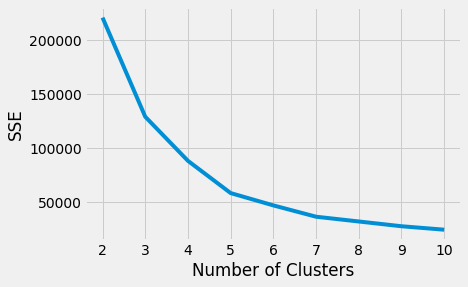

5


In [12]:
!pip install kneed

import matplotlib.pyplot as plt

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

X = out_merge.iloc[:, 1:].values


kmeans_kwargs = {
   "init": "k-means++",
   "n_init": 10,
   "max_iter": 500,
   "random_state": 99,
}
   
# A list holds the SSE values for each k
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
        
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(
     range(2, 11), sse, curve="convex", direction="decreasing"
)

print (kl.elbow)


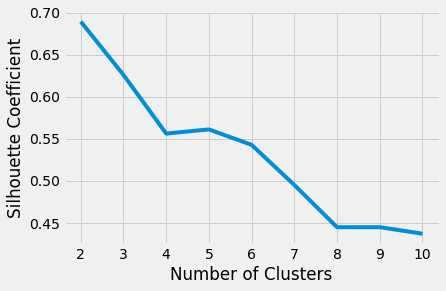

In [13]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Aplicar o k-means, com 4 classes aos dados:

In [14]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(X)

labels = kmeans.labels_

out_merge['CLASSE'] = labels

out_merge[['ID','CLASSE']].head(5)

,ID,CLASSE
0,1,0
1,2,3
2,3,3
3,4,3
4,5,0


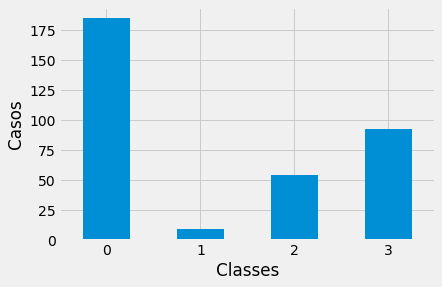

In [15]:
#Classes de acordo ao número total de casos de COVID
out_merge.groupby('CLASSE').agg('count')['ID'].plot.bar(x='lab', y='val', rot=0);
plt.xlabel("Classes")
plt.ylabel("Casos");

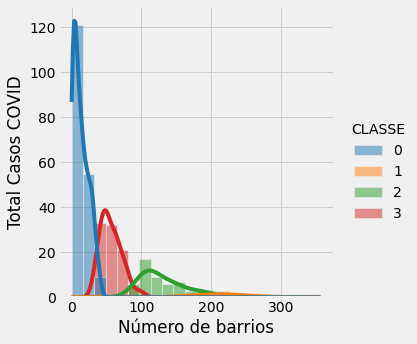

In [16]:
#Distribução das classes de acordo ao número total de casos de COVID
out_merge["SUM"] = out_merge.drop(["CLASSE", "ID"], axis=1).sum(axis=1)

sns.displot(out_merge, x="SUM", hue="CLASSE", kde=True, palette="tab10")
plt.ylabel("Total Casos COVID");
plt.xlabel("Número de barrios");

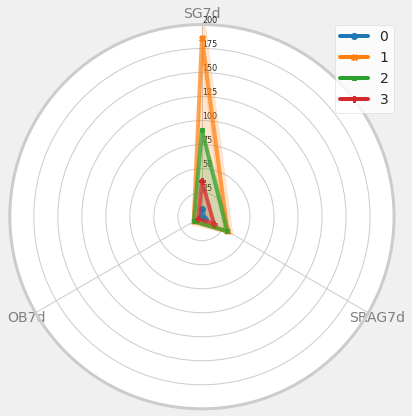

In [17]:
#numero total de casos de COVID
plt.figure(figsize=(6,6)) 
x_covid= pd.melt(out_merge, id_vars=['ID', "CLASSE", "SUM"], var_name='description')

sns.set_style("whitegrid")
ax = sp.spiderplot(x = "description", y="value", hue="CLASSE", style="CLASSE",
                   data=x_covid, dashes=False, palette="tab10", rref=0)
ax.set_rlim([0,200])
ax.legend(loc="upper right",
           bbox_to_anchor=(1., 1.),
           borderaxespad=0.)
plt.tight_layout()
plt.show()

In [18]:
# dataset com informação de faixas etárias
XE = pd.merge(out_merge, censo_join[['ID','ABAIXO1ANO','1A9ANOS','10A19ANOS','20A29ANOS','30A39ANOS','40A49ANOS','50A59ANOS','ACIMA60ANOS']])
# dataset com informação de número de idosos
XI = pd.merge(out_merge, censo_join[['ID','ACIMA60ANOS']])
# dataset com informação de faixas de renda
XR = pd.merge(out_merge, censo_join[['ID','ATEMEIOSALARIO','DEMEIOA1SALARIO','DE1A2SALARIOS','DE2A3SALARIOS','DE3A5SALARIOS','DE5A10SALARIOS','DE10A15SALARIOS','DE15A20SALARIOS','MAISDE20SALARIOS','SEMSALARIO']]) 
# dataset com informação de número de praças
XP = pd.merge(out_merge, censo_join[['ID','PRACAS']])
# dataset com informação de número de empresas
XN = pd.merge(out_merge, censo_join[['ID','EMPRESAS OUTROS GROUPOS','EMPRESAS PEQUENO PORTE']])

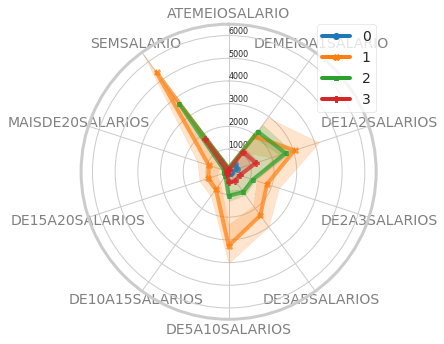

In [19]:
#informação de faixas de renda
plt.figure(figsize=(6,6)) 
xr= pd.melt(XR, id_vars=['ID', "SG7d", "SRAG7d", "OB7d", "CLASSE", "SUM"], var_name='description')

sns.set_style("whitegrid")
ax = sp.spiderplot(x = "description", y="value", hue="CLASSE", style="CLASSE",
                   data=xr, dashes=False, palette="tab10", rref=0)
ax.set_rlim([0,6500])
ax.legend(loc="upper right",
           bbox_to_anchor=(1., 1.),
           borderaxespad=0.)
plt.tight_layout()
plt.show()

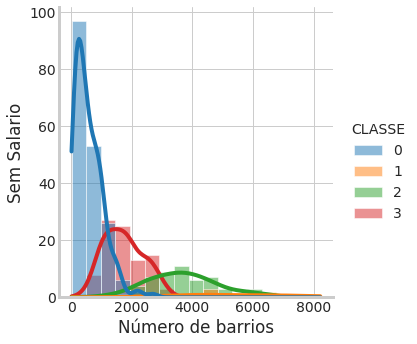

In [20]:
#Sem Salario
sns.displot(XR, x="SEMSALARIO", hue="CLASSE", kde=True, palette="tab10")
plt.ylabel("Sem Salario");
plt.xlabel("Número de barrios");

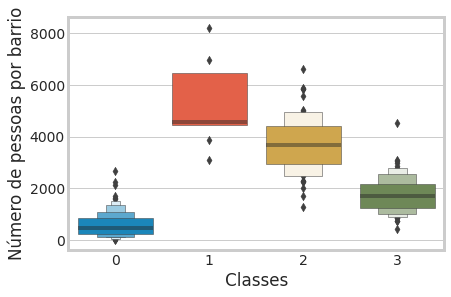

In [28]:
#Sem Salario
sns.boxenplot(data=XR, y="SEMSALARIO", x="CLASSE");
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por barrio");

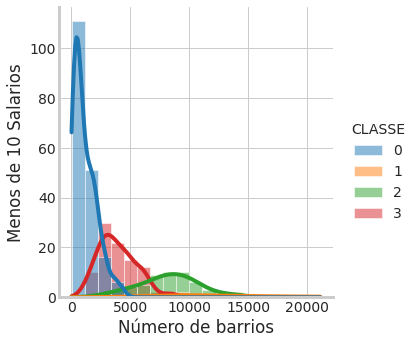

In [22]:
#Menos de 10 Salarios
XR["MENOSDE10SALARIOS"] = XR[['ATEMEIOSALARIO','DEMEIOA1SALARIO','DE1A2SALARIOS','DE2A3SALARIOS','DE3A5SALARIOS','DE5A10SALARIOS']].sum(axis=1)
sns.displot(XR, x="MENOSDE10SALARIOS", hue="CLASSE", kde=True, palette="tab10")
plt.ylabel("Menos de 10 Salarios");
plt.xlabel("Número de barrios");

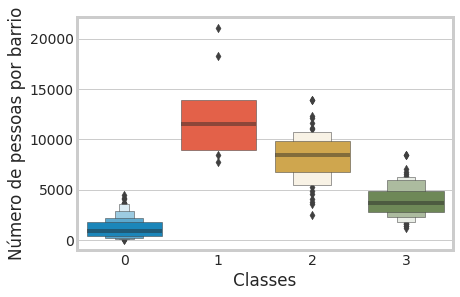

In [27]:
#Menos de 10 Salarios
sns.boxenplot(data=XR, y="MENOSDE10SALARIOS", x="CLASSE");
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por barrio");

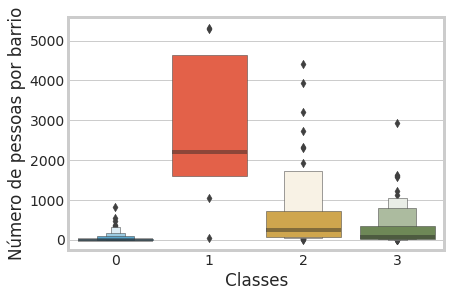

In [29]:
#Mais de 10 Salarios
XR["MAISDE10SALARIOS"] = XR[['DE10A15SALARIOS','DE15A20SALARIOS','MAISDE20SALARIOS']].sum(axis=1)
sns.boxenplot(data=XR, y="MAISDE10SALARIOS", x="CLASSE");
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por barrio");

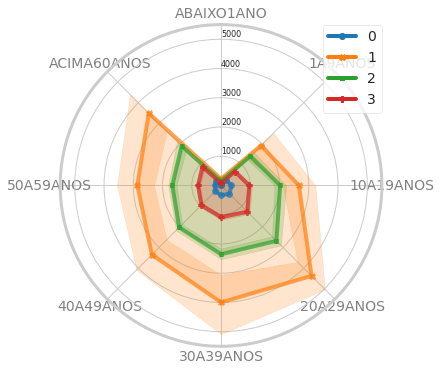

In [25]:
#faixas etárias
plt.figure(figsize=(6,6))
xe= pd.melt(XE, id_vars=['ID', "SG7d", "SRAG7d", "OB7d", "CLASSE", "SUM"], var_name='description')

sns.set_style("whitegrid")
ax = sp.spiderplot(x = "description", y="value", hue="CLASSE", style="CLASSE",
                   data=xe, dashes=False, palette="tab10", rref=0)
ax.set_rlim([0,5500])
ax.legend(loc="upper right",
           bbox_to_anchor=(1., 1.),
           borderaxespad=0.)
plt.tight_layout()
plt.show()